# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [ ]:
import numpy as np
import copy

from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn


### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [ ]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [ ]:
class Linear(Module):
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):

        self.in_features = in_features
        self.out_features = out_features
        self.W = np.random.random((in_features, out_features))
        self.b = np.random.random(out_features)
    
    def forward(self, x: np.ndarray) -> np.ndarray:

        self.x = x       
        return self.x @ self.W + self.b
    
    def backward(self, d: np.ndarray) -> np.ndarray:

        self.der_x = d @ self.W.T
        self.der_W = self.x.T @ d
        if d.ndim >1:
            self.der_b = d.sum(axis=0)
        elif d.ndim == 1:
            self.der_b = d
        return self.der_x
        
    def update(self, alpha: float) -> NoReturn:

        if self.x.ndim >1:
            n = self.x.shape[0]
        else:
            n = 1
      

        self.W -= alpha/n * self.der_W
        self.b -= alpha/n * self.der_b

In [ ]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        
        self.x = x
        y = np.maximum(0, self.x)
        return y
        
    def backward(self, d) -> np.ndarray:

        self.der = np.maximum(0, np.sign(self.x))
        self.der = d * self.der
        return self.der
        
        
class Softmax(Module):
    """
    Слой, соответствующий функции активации Softmax.
    """
    def __init__(self):
        pass
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.y = np.zeros_like(x)

        if x.ndim == 1:
            numer = np.exp(x - np.max(x))
            denom = np.sum(numer)
            self.y = numer / denom
        else:
            for i in range(x.shape[0]):
                numer = np.exp(x[i] - np.max(x[i]))
                denom = np.sum(numer)
                self.y[i] = numer / denom
        self.X = x     
        return self.y

        
    def backward(self, d) -> np.ndarray:

        return self.y - d

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [ ]:
 class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01): 

        self.modules = modules
        self.modules.append(Softmax())
        self.epochs = epochs
        self.alpha = alpha
        
            
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> NoReturn:
      
        with_labels = np.column_stack((X, y))
        batches_num= int(np.ceil(len(with_labels)/batch_size))

        for j in range(self.epochs):
            np.random.shuffle(with_labels)
            batches = [with_labels[i* batch_size:(i+1)* batch_size] for i in range(batches_num)]
            
            for sample in batches:               
                batch, y_true = sample[:,:-1], sample[:,-1]



                dummy = np.zeros((int(batch.shape[0]), len(np.unique(y))))
                for i in range(int(batch.shape[0])):
                    dummy[i][int(y_true[i])] = 1

                probs = batch
                for layer in self.modules:
                    probs = layer.forward(probs)               
                y_pred = np.argmax(probs, axis=1)

                der = self.modules[-1].backward(dummy)
                for layer in self.modules[-2::-1]:
                    der = layer.backward(der)
                    layer.update(self.alpha)

             
            
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        probs = X
        for layer in self.modules:
            probs = layer.forward(probs)
        return probs
    
    
    def predict(self, X) -> np.ndarray:
        classes = self.predict_proba(X)
        return np.argmax(classes, axis=1)

In [ ]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [ ]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([
    Linear(2, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.9575


In [ ]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier([
    Linear(2, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 3)
])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.9525


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32,10)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    y_new = model(X)
    return F.cross_entropy(y_new, y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [ ]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [ ]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.140579621810913 | Test loss 1.9315820199966431
Epoch 1 | Train loss 1.833824192276001 | Test loss 1.7264047985076905
Epoch 2 | Train loss 1.6782695804595946 | Test loss 1.6339229160308837
Epoch 3 | Train loss 1.596324924659729 | Test loss 1.5611308473587036
Epoch 4 | Train loss 1.5428171305084228 | Test loss 1.5275204820632935
Epoch 5 | Train loss 1.5056361962509155 | Test loss 1.489925717163086
Epoch 6 | Train loss 1.4726164414215088 | Test loss 1.4631167400360108
Epoch 7 | Train loss 1.4389764136505128 | Test loss 1.4288948017120362
Epoch 8 | Train loss 1.405932275428772 | Test loss 1.3940167852401733
Epoch 9 | Train loss 1.3694819753265381 | Test loss 1.363820463180542
Epoch 10 | Train loss 1.335168171005249 | Test loss 1.3410392478942872
Epoch 11 | Train loss 1.3079902465057374 | Test loss 1.3240881557464599
Epoch 12 | Train loss 1.2874009035491942 | Test loss 1.2972675033569336
Epoch 13 | Train loss 1.2688093577957154 | Test loss 1.2928006191253663
Epoch 14 

Построим график функции потерь

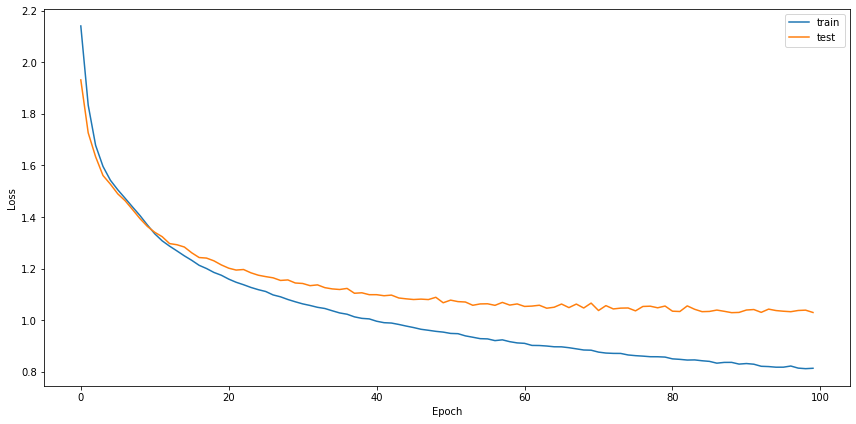

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [ ]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6428
Precision [0.65639166 0.76536885 0.5098242  0.46511628 0.57328016 0.58118701
 0.70914397 0.69246032 0.74218009 0.70519099]
Recall [0.724 0.747 0.493 0.44  0.575 0.519 0.729 0.698 0.783 0.72 ]
Mean Precision 0.6400143529137235
Mean Recall 0.6428
